# Applying Logistic Regression on Amazon fine food reviews Dataset

__Here we will be using Grid search CV for hyperparameter tuning.__

<h2>Introduction to the Dataset</h2>


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
import sqlite3
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

##### 2. Connecting to Amazon food review dataset

In [8]:
con=sqlite3.connect('./database.sqlite')
filtered_data=pd.read_sql_query("""select * from reviews where score!=3""",con)
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
actual_score=filtered_data['Score']
PositiveNegative=actual_score.map(partition)
filtered_data['Score']=PositiveNegative
print(filtered_data.shape)
filtered_data.head()


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##### 3. Sorting our data on the basis of date and removing the Duplicate reviews

In [9]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
print(final.shape)

(364173, 10)


##### 4. we are also removing the rows which has HelpfulnessDenominator greater then HelpfulnessNumerator because its not practically possile 

In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
print(final.shape)

(364171, 10)


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#### we are also cleaning our text of html tags , stop words, and puncuations

In [13]:
# find sentences containing HTML tags

import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [89]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'in', 'theirs', 'ourselves', 'mightn', 'an', 'by', 'more', 'doing', 'out', 'your', 'has', 'y', 'if', 'of', 'whom', 'their', 'below', 'yours', 'haven', 'further', "she's", 'yourself', 'here', 'while', 'a', 'from', 'again', 'when', 'very', 'we', 'he', 'herself', 'under', 'just', 'wouldn', "doesn't", "didn't", "mustn't", 'or', 'himself', 'shan', 'not', 'it', 'such', "that'll", 'have', 'won', 'why', 'her', 'same', 'i', 'how', 'over', 'there', 'do', 'other', 'they', 'what', 'd', 'doesn', "you've", 'myself', 'each', 'yourselves', 'hasn', 'ours', 'don', 's', "hasn't", 'are', "you'll", 'all', 'themselves', 'only', 'isn', 'on', "should've", 'against', 'can', 'so', 'should', "don't", "won't", 'll', "weren't", 'to', 'these', 'ain', "needn't", 'and', 'having', 'no', 'will', 'between', 'once', 'few', "wouldn't", "haven't", 'its', 'hadn', 'own', 'as', 'who', 'she', 'wasn', 'most', 'with', 'now', 'being', 'o', 'for', "couldn't", "you're", 'me', 'because', 'his', 'does', 'were', 'itself', 'at', 'my',

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [16]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [17]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

##### 6. Here we are Seperating all the review information of user on the basis of their Score i.e positive or negative. 
Then we are taking 306913 positive and 57087 negative reviews respectively from positive and negative data frame and we are concating them together in one data frame bigdata. We are also taking the scores of these 364000 reviews seperately in s1.
We then divide 364000 reviews to train and test data, and we convert the text column of the test and train into BOW. 


In [18]:
final.shape

(364171, 11)

In [19]:
total_data=final.sample(364000)

In [44]:
conn = sqlite3.connect('total_data.sqlite')

In [ ]:
conn = sqlite3.connect('total_data.sqlite')
c=conn.cursor()
conn.text_factory = str
total_data.to_sql('total', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [45]:
positive_data=pd.read_sql_query("""select * from total where score='positive'""",conn)
negative_data=pd.read_sql_query("""select * from total where score='negative'""",conn)

In [ ]:
print(positive_data.shape)
print(negative_data.shape)

In [46]:
positive_data2000=positive_data.head(12500)
negative_data2000=negative_data.head(12500)
bigdata = positive_data2000.append(negative_data2000, ignore_index=True)
print(bigdata.shape)

(25000, 12)


In [47]:
total_data=bigdata

In [48]:
#Again sorting our data in Ascending order
sorted_data=total_data.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')


In [9]:
sorted_data[154:161]

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
310,1924,2100,B000EPP56U,A1G6Q2NQMJ2C3X,ARealAVFan,8,8,positive,1149897600,Excellent rice crackers,I always disliked soggy or soft crackers with ...,b'alway dislik soggi soft cracker peanut butte...
5191,27868,30386,B000E1DSJU,A2PKM6BZPO2I9P,Susan N. Jackson,1,1,positive,1150329600,The Best Marinade,I have tried several marinades over the years ...,b'tri sever marinad year hand best found favor...
5059,12418,13550,B000AYDHD8,A2E2BDF383GF6H,J. Cybulski,7,20,positive,1150416000,Serving suggestion,"If you have 96 people to serve, this would be ...",b'peopl serv would excel purchas serv howev wo...
6934,257122,278754,B0007SNZ52,A3LY49ZL3LHR0G,D. Willis,4,6,positive,1150502400,best ice cream ever,This cocoa is amazing with its wonderfully str...,b'cocoa amaz wonder strong sin good flavor nev...
1119,220116,238604,B000CRIUNU,A17PGJU80JGBIH,Charles,2,2,positive,1150588800,"Oh, this is for breakfast?",I found this brand in a local health food stor...,b'found brand local health food store recent t...
15427,443376,479420,B000AQJRWG,A120JZI582VFIU,Kelsey,5,15,negative,1150675200,absolutely disgusting,This small package of noodles came to me in a ...,b'small packag noodl came huge box thought hug...
13536,250601,271716,B0000DGFCO,A1XKFPYY0C630R,Peter Beckerle,23,28,negative,1150761600,Many issues to contend with,I also received the wrong tree the first time....,b'also receiv wrong tree first time first tree...


In [49]:
bigdata=sorted_data
s1=bigdata['Score']
print(s1.shape)
print(s1.head())

(25000,)
371      positive
11666    positive
24919    negative
7331     positive
12174    positive
Name: Score, dtype: object


In [50]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(bigdata, s1, test_size=0.3, random_state=0,shuffle = False, stratify = None)

In [12]:
#BOW for 254800 Train points
count_vect = CountVectorizer() #in scikit-learn
big_data = count_vect.fit_transform(X_1['Text'].values)
print(big_data.shape)


(17500, 27252)


In [13]:
#BOW for 109200 Test points
test_data = count_vect.transform(X_test['Text'].values)
print(test_data.shape)

(7500, 27252)


##### Standardizing our Train and Test BOW vectors 

In [14]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardizedtest_data = StandardScaler(with_mean=False).fit_transform(test_data)
print(standardizedtest_data.shape)
test_data=standardizedtest_data

(7500, 27252)


C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(big_data)
print(standardized_data.shape)

(17500, 27252)


C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
big_data=standardized_data

# Confusion Matrix Function

In [17]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


#### Using Logistic Regression now

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

# FOR BOW
__With Grid Search CV__

In [19]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVC
X = big_data
y = y_1
clf=SVC()
param_search = [{'gamma': [1.0,0.1,0.01,0.001, 0.0001],'C': [10**-2, 10**0, 10**1 ,10**2, 10**3]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(clf, param_search, scoring = 'accuracy', cv=my_cv,n_jobs=-1)
gsearch.fit(X, y)



GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000016771811518>,
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'gamma': [1.0, 0.1, 0.01, 0.001, 0.0001], 'C': [0.01, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [20]:
print("Best HyperParameter: ",gsearch.best_params_)

Best HyperParameter:  {'C': 10, 'gamma': 0.0001}


In [21]:
clf = SVC(C=10,gamma=0.0001)
clf.fit(X,y)
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 82%


#### Confusion matrix , Precision, Recall, F-Score

In [22]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[3437  563]
 [ 715 2785]]
Precision :- 0.831839904421
Recall    :- 0.795714285714
F1 Score  :- 0.831839904421


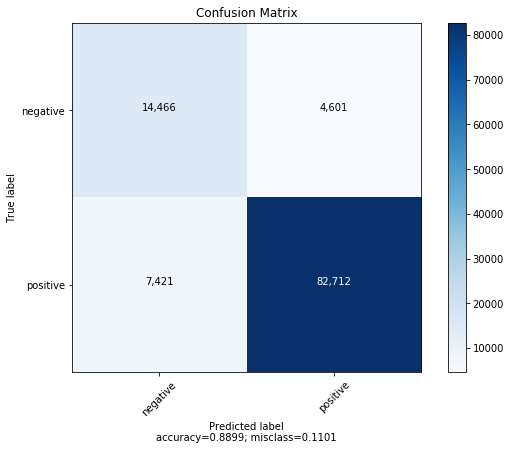

In [23]:

plot_confusion_matrix(cm           = np.array([[ 14466  ,4601],[7421 ,82712]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

# Using Randomized Search CV

In [24]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform as sp_rand

clf = SVC()
param_dist = {'gamma':[1.0,0.1,0.01,0.001, 0.0001],'C':[10**-2, 10**0, 10**1,20,30,40,50 ,10**2, 10**3]} 
mycv = TimeSeriesSplit(n_splits=3) #For time based splitting
rscv = RandomizedSearchCV(clf,param_dist,cv=mycv,verbose=1,n_iter=15)
rscv.fit(X,y)
print("Best HyperParameter: ",rscv.best_params_)

Wall time: 0 ns
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 190.1min finished


Best HyperParameter:  {'gamma': 0.0001, 'C': 10}


In [25]:
clf = SVC(C=50,gamma=0.001)
clf.fit(X,y)
y_pred=clf.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 68%


In [26]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[3721  279]
 [2099 1401]]
Precision :- 0.833928571429
Recall    :- 0.400285714286
F1 Score  :- 0.833928571429


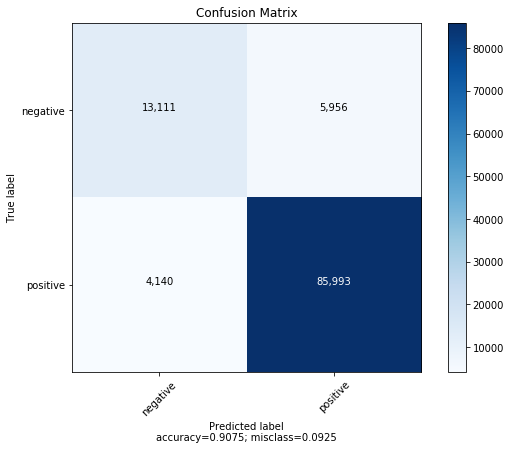

In [27]:
plot_confusion_matrix(cm           = np.array([[ 13111   ,5956],[4140  ,85993]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__SGD Classifier__

In [31]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
tscv = TimeSeriesSplit(n_splits=3).split(X)
param_dist = {'penalty':['l1','l2'],'alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
gridcv = GridSearchCV(clf,param_dist,cv=tscv,verbose=1)
gridcv.fit(X,y)
print("Best HyperParameter: ",gridcv.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

Best HyperParameter:  {'alpha': 1, 'penalty': 'l2'}


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   10.4s finished
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [36]:
clf = SGDClassifier(alpha=1,penalty='l2')
clf.fit(X,y)
y_pred = clf.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#precision From above Confusion Metric
pre=(gb[1,1]+0.0)/sum(gb[:,1])
print("Precision is",pre)
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
print("Recall is",recall)
# caculating F1 Score By using HP i.e 
#F1=2*TP/2*TP+FP+FN
F1=(2*pre*recall)/(pre+recall)
print("F1 Score is",F1)



Test accuracy for best estimator is 87%
[[3482  518]
 [ 450 3050]]
Precision is 0.854820627803
Recall is 0.871428571429
F1 Score is 0.863044708546


C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


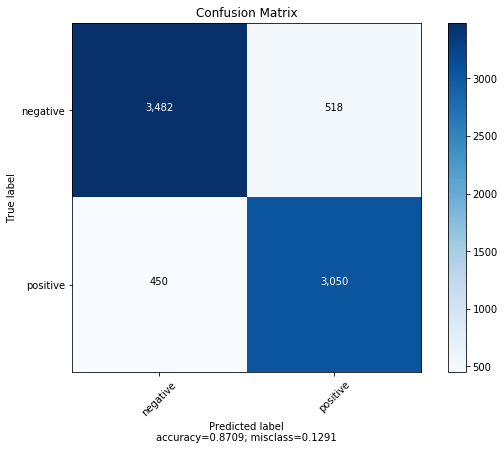

In [37]:
plot_confusion_matrix(cm           = np.array([[ 3482  ,518],[450 ,3050]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

### Now Computing Using Tf-Idf Features

In [67]:
#Tf-IDF for 254800 Train points
tf_idf_vect = TfidfVectorizer()
big_data = tf_idf_vect.fit_transform(X_1['Text'].values)
print(big_data.shape)


(17500, 27252)


In [68]:
#Tf-Idf for 109200 Test points
test_data = tf_idf_vect.transform(X_test['Text'].values)
print(test_data.shape)

(7500, 27252)


##### Standardizing our Train and Test BOW vectors 

In [69]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardizedtest_data = StandardScaler(with_mean=False).fit_transform(test_data)
print(standardizedtest_data.shape)
test_data=standardizedtest_data

(7500, 27252)


In [70]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(big_data)
print(standardized_data.shape)

(17500, 27252)


In [71]:
big_data=standardized_data

__With Grid Search CV__

In [72]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVC
X = big_data
y = y_1
clf=SVC()
param_search = [{'gamma': [1.0,0.1,0.01,0.001, 0.0001],'C': [10**-2, 10**0, 10**1 ,10**2, 10**3]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(clf, param_search, scoring = 'accuracy', cv=my_cv,n_jobs=-1)
gsearch.fit(X, y)

print("Best HyperParameter: ",gsearch.best_params_)

Best HyperParameter:  {'C': 10, 'gamma': 0.0001}


In [73]:

clf = SVC(C=10,gamma=.0001)
clf.fit(X,y)
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 82%


#### Confusion matrix , Precision, Recall, F-Score

In [74]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[3325  675]
 [ 664 2836]]
Precision :- 0.807747080604
Recall    :- 0.810285714286
F1 Score  :- 0.807747080604


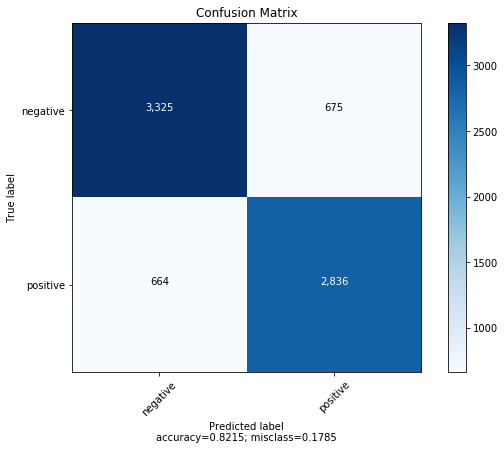

In [75]:

plot_confusion_matrix(cm           = np.array([[ 3325    ,675],[664  ,2836]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__With Randomized Search CV__

In [76]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform as sp_rand

clf = SVC()
param_dist = {'gamma':[1.0,0.1,0.01,0.001, 0.0001],'C':[10**-2, 10**0, 10**1,20,30,40,50 ,10**2, 10**3]} 
mycv = TimeSeriesSplit(n_splits=3) #For time based splitting
rscv = RandomizedSearchCV(clf,param_dist,cv=mycv,verbose=1,n_iter=15)
rscv.fit(X,y)
print("Best HyperParameter: ",rscv.best_params_)

Wall time: 0 ns
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 222.3min finished


Best HyperParameter:  {'gamma': 0.0001, 'C': 1000}


In [77]:
clf = SVC(C=1000,gamma=0.0001)
clf.fit(X,y)
y_pred=clf.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 80%


In [78]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[3276  724]
 [ 703 2797]]
Precision :- 0.794376597558
Recall    :- 0.799142857143
F1 Score  :- 0.794376597558


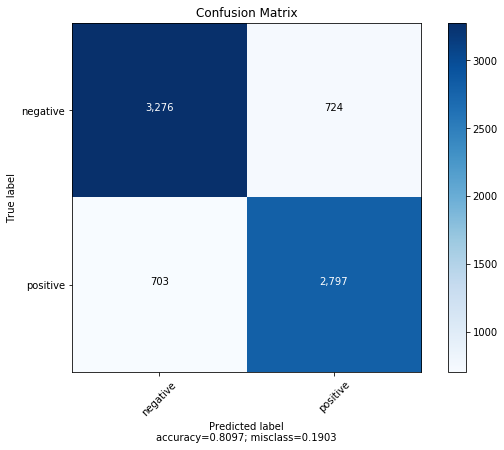

In [79]:
plot_confusion_matrix(cm           = np.array([[ 3276,724],[703,2797]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Using SGD Classifier__

In [80]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
tscv = TimeSeriesSplit(n_splits=3).split(X)
param_dist = {'penalty':['l1','l2','elasticnet'],'alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 
gridcv = GridSearchCV(clf,param_dist,cv=tscv,verbose=1)
gridcv.fit(X,y)
print("Best HyperParameter: ",gridcv.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\l

C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Best HyperParameter:  {'alpha': 0.05, 'penalty': 'elasticnet'}


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   18.6s finished
C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [81]:
clf = SGDClassifier(alpha=0.05,penalty='elasticnet')
clf.fit(X,y)
y_pred = clf.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#precision From above Confusion Metric
pre=(gb[1,1]+0.0)/sum(gb[:,1])
print("Precision is",pre)
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
print("Recall is",recall)
# caculating F1 Score By using HP i.e 
#F1=2*TP/2*TP+FP+FN
F1=(2*pre*recall)/(pre+recall)
print("F1 Score is",F1)


C:\Users\Yaakuza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)



Test accuracy for best estimator is 86%
[[3498  502]
 [ 503 2997]]
Precision is 0.856530437268
Recall is 0.856285714286
F1 Score is 0.856408058294


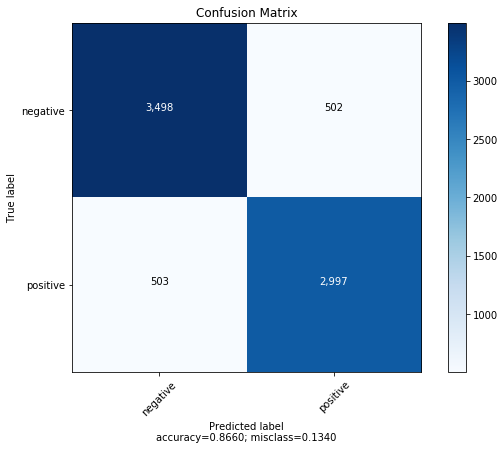

In [82]:
plot_confusion_matrix(cm           = np.array([[ 3498,502],[503,2997]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__Now Trying on Word2Vec__

In [90]:
from nltk.stem.porter import PorterStemmer
# Train your own Word2Vec model using your own text corpus for train Data
import gensim
i=0
list_of_sent_train=[]
for sent in X_1['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
    

In [91]:
# min_count = 5 considers only words that occured atleast 5 times
import gensim
from gensim import models
from gensim.models import Word2Vec, KeyedVectors
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8624
sample words  ['i', 'can', 'remember', 'seeing', 'the', 'show', 'when', 'it', 'on', 'television', 'years', 'ago', 'was', 'a', 'child', 'my', 'sister', 'later', 'bought', 'me', 'which', 'have', 'to', 'this', 'day', 'im', 'thirty', 'something', 'used', 'series', 'of', 'books', 'did', 'student', 'teaching', 'for', 'turned', 'whole', 'school', 'am', 'now', 'purchasing', 'along', 'with', 'children', 'tradition', 'lives', 'thought', 'movie', 'so']


In [92]:

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

17500
50


In [93]:
# Train your own Word2Vec model using your own text corpus for test Data
import gensim
i=0
list_of_sent_test=[]
for sent in X_test['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
    

In [94]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5580
sample words  ['i', 'emailed', 'customer', 'service', 'and', 'asked', 'if', 'the', 'treats', 'were', 'filled', 'with', 'sweet', 'potato', 'they', 'assured', 'me', 'that', 'theyd', 'checked', 'manufacturer', 'confirmed', 'did', 'in', 'fact', 'have', 'a', 'center', 'however', 'ones', 'received', 'not', 'feel', 'like', 'was', 'to', 'by', 'because', 'didnt', 'want', 'take', 'time', 'actually', 'check', 'into', 'it', 'this', 'good', 'drink', 'drank']


In [95]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

7500
50


##### Standardizing our Train and Test word2vec vectors 

In [96]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
#np.isnan(sent_vectors_train.values.any())
#Where sent_vectors_train is my pandas Dataframe 
standardized_data_train = StandardScaler(with_mean=False).fit_transform(sent_vectors_train)
print(standardized_data_train.shape)

(17500, 50)


In [97]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
standardized_data_test = StandardScaler(with_mean=False).fit_transform(sent_vectors_test)
print(standardized_data_test.shape)

(7500, 50)


In [98]:
big_data=standardized_data_train

In [99]:
X=big_data
test_data=standardized_data_test
y=y_1

__Using Grid Search CV__

In [102]:
#https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sciimport xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVC
X = big_data
y = y_1
clf=SVC()
param_search = [{'gamma': [1.0,0.1,0.01,0.001, 0.0001],'C': [10**-2, 10**0, 10**1 ,10**2, 10**3]}]

my_cv = TimeSeriesSplit(n_splits=3).split(X)
gsearch = GridSearchCV(clf, param_search, scoring = 'accuracy', cv=my_cv,n_jobs=-1)
gsearch.fit(X, y)

print("Best HyperParameter: ",gsearch.best_params_)

Best HyperParameter:  {'C': 1, 'gamma': 0.01}


In [101]:
clf = SVC(C=1,gamma=0.01)
clf.fit(X,y)
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 60%


#### Confusion matrix , Precision, Recall, F-Score

In [103]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[2145 1855]
 [1113 2387]]
Precision :- 0.562706270627
Recall    :- 0.682
F1 Score  :- 0.562706270627


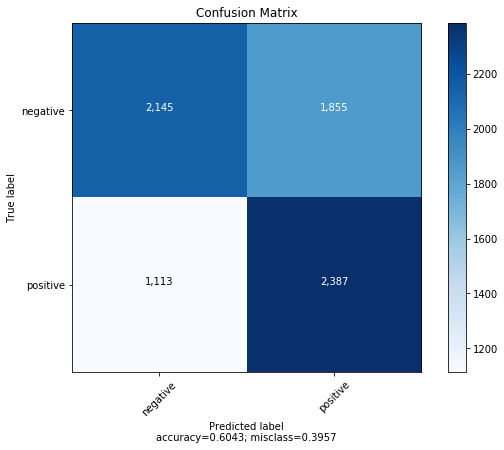

In [104]:

plot_confusion_matrix(cm           = np.array([[2145,1855],[1113,2387]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

__With Randomized Search CV__

In [105]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform as sp_rand

clf = SVC()
param_dist = {'gamma':[1.0,0.1,0.01,0.001, 0.0001],'C':[10**-2, 10**0, 10**1,20,30,40,50 ,10**2, 10**3]} 
mycv = TimeSeriesSplit(n_splits=3) #For time based splitting
rscv = RandomizedSearchCV(clf,param_dist,cv=mycv,verbose=1,n_iter=15)
rscv.fit(X,y)
print("Best HyperParameter: ",rscv.best_params_)

Wall time: 0 ns
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 20.8min finished


Best HyperParameter:  {'gamma': 0.001, 'C': 20}


In [108]:
clf = SVC(C=20,gamma=0.001)
clf.fit(X,y)
y_pred=gsearch.predict(test_data)
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\nTest accuracy for best estimator is %d%%' % ( acc))


Test accuracy for best estimator is 60%


In [109]:
gb=metrics.confusion_matrix(y_test,y_pred)
print(gb)
#plotting the confusion matrix
#Plot of Confusion Metric
#precision From above Confusion Metric
#Recall From above Confusion Metric 
recall=(gb[1,1]+0.0)/sum(gb[1,:])
pre=(gb[1,1]+0.0)/sum(gb[:,1])
F1=(2*pre*recall)/(pre+recall)
print("Precision :-",pre)
print("Recall    :-",recall)
print("F1 Score  :-",pre)

[[2145 1855]
 [1113 2387]]
Precision :- 0.562706270627
Recall    :- 0.682
F1 Score  :- 0.562706270627


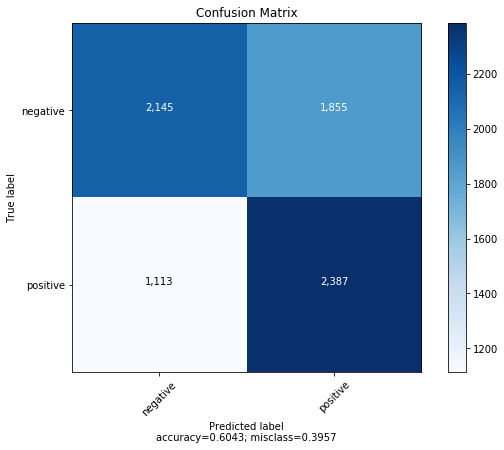

In [110]:
plot_confusion_matrix(cm           = np.array([[2145,1855],[1113,2387]]), 
                      normalize    = False,
                      target_names = ['negative', 'positive'],
                      title        = "Confusion Matrix")

# Conclusion

<style>
    .data-table {
        border-collapse: collapse;
    }
    .border-bottom {
        border-bottom: 1px solid #000;
    }
</style>

<table class="data-table">
    <tr>
        <th>Model</th>
        <th>C, Gamma, Alpha</th>
        <th>Test Accuracy</th>
        <th>F1-Score</th>
    </tr>
    <tr>
        <td class="border-bottom">&nbsp;GridSearch CV Using&nbsp;BOW</td>
        <td class="border-bottom">C=10, gamma=0.0001</td>
        <td class="border-bottom">82%</td>
        <td class="border-bottom">0.83</td>
    </tr>
    <tr>
        <td>Randomized Search CV Using&nbsp;BOW</td>
        <td>C=10, gamma=0.0001</td>
        <td>68%</td>
        <td>0.83</td>
    </tr>
    <tr>
        <td>SGD Classifier Using&nbsp;BOW</td>
        <td>alpha=1, penalty=l2</td>
        <td>87%</td>
        <td>0.86</td>
    </tr>
    <tr>
        <td>&nbsp;GridSearch CV Using&nbsp;Tf-Idf</td>
        <td>C=10, gamma=0.0001</td>
        <td>82%</td>
        <td>0.80</td>
    </tr>
    <tr>
        <td>Randomized Search CV Using Tf-Idf</td>
        <td>C=1000, gamma=0.0001</td>
        <td>80%</td>
        <td>0.79</td>
    </tr>
    <tr>
        <td>SGD Classifier Using Tf-Idf</td>
        <td>alpha=0.05, penalty=elasticnet</td>
        <td>86%</td>
        <td>0.85</td>
    </tr>
    <tr>
        <td class="border-bottom">&nbsp;GridSearch CV Using Word2Vec</td>
        <td class="border-bottom">C=1, gamma=0.01</td>
        <td class="border-bottom">60%</td>
        <td class="border-bottom">0.56</td>
    </tr>
    <tr>
        <td>Randomized Search CV Using Word2Vec</td>
        <td>C=20, gamma=0.001</td>
        <td>60%</td>
        <td>0.56</td>
    </tr>
</table>

1. Best Model is on Bag of Words with Grid Search, with the test accuracy of 82% ,F-1 Score=0.83 , C=10, gamma=0.0001.
2. So far SVM is only the best nearest algorithm to Logistic regression in terms of accuracy.
3. Best Model is SGD Classifier on Bag of Words, with the test accuracy of 87% , alpha=1 and penalty=l2.